In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import os, sys
# from statsmodels.nonparametric.smoothers_lowess import lowess
from collections import defaultdict

# file_path = sys.argv[1]
# file_path = os.path.join('data','raw',file_name)
# file_path = "m=4 to.txt"

def read_parameters(file_path):
    with open(file_path, 'r') as file:
        # Read the entire file content
        content = file.read()

        # Use regex to extract the parameters inside the curly braces
        match = re.search(r'Parameters\s*=\s*{(.+?)}', content)
        if match:
            param_str = match.group(1)
            
            # Split the parameters into key-value pairs
            param_pairs = param_str.split(';')
            
            # Create a dictionary by splitting each pair at the '=' sign
            param_dict = {}
            for pair in param_pairs:
                if pair.strip():  # Ignore empty strings
                    key, value = pair.split('=')
                    param_dict[key.strip()] = float(value.strip())
                    
            return param_dict
        else:
            raise ValueError("No parameters found in the file.")


In [28]:

def extract_data(file_path):
    H_params = []  # To store Hdc values
    frequency = None  # To store the frequency values (we only need one set)
    s21_1100 = []  # To store all S21 values for each Hdc
    s21_225 = []  # To store all S21 values for each Hdc

    with open(file_path, 'r') as file:
        lines = file.readlines()
        param_read = False  # To track if the parameters have been read
        current_s21 = []  # To temporarily store the current S21 values
        current_frequency = []  # To temporarily store the frequency values
        frequencies = np.linspace(4.3, 6.4, 3001)
        
        for line in lines:
            # Ignore comment lines
            # if line.startswith('#'):
                # continue

            # Extract the first set of parameters
            if 'Parameters =' in line and not param_read:
                match = re.search(r'Hdc=([0-9.]+)', line)
                idx = 0
                if match:
                    # First set of parameters
                    Hdc_value = float(match.group(1))
                    H_params.append(Hdc_value)
                    print(Hdc_value)
                    param_read = True  # Mark that parameters are read
                    continue

            # For subsequent sets of parameters, only extract Hdc
            if 'Parameters =' in line and param_read:
                match = re.search(r'Hdc=([0-9.]+)', line)
                idx = 0
                if match:
                    Hdc_value = float(match.group(1))
                    H_params.append(Hdc_value)
                    if H_params[-2] == 1100:
                        s21_1100.append(current_s21)
                    elif H_params[-2] == 225:
                        s21_225.append(current_s21)
                    else:
                        print("Hdc value not recognized.")
                    # s21.append(current_s21)
                    current_s21 = []
                    continue

            # Handle frequency and S21 data lines
            data = line.strip().split()
            if len(data) == 2:
                freq_value = float(data[0])
                freq_value = frequencies[idx]
                idx += 1
                s21_value = float(data[1])

                if frequency is None:
                    current_frequency.append(freq_value)

                current_s21.append(s21_value)

        # Add the last block of S21 data
        if current_s21:
            # s21.append(smoothed_s21)
            if H_params[-1] == 1100:
                s21_1100.append(current_s21)
            elif H_params[-1] == 225:
                s21_225.append(current_s21)
            else:
                print("Hdc value not recognized.")
            # s21.append(current_s21) 

    # Final processing
    if frequency is None:
        frequency = np.array(current_frequency)

    H_params = np.array(H_params)
    # s21 = np.array(s21).T  # Convert S21 to a 2D array (transpose for correct dimensions)
    # s21_1100 = np.array(s21_1100)
    # s21_225 = np.array(s21_225)
    # max_shape_1100 = max(s21_1100.shape)
    # max_shape_225 = max(s21_225.shape)
    # s21_1100 = np.array(s21_1100[:max_shape_1100,:max_shape_1100]).T
    # s21_225 = np.array(s21_225[:max_shape_225,:max_shape_225]).T

    return frequency, H_params, s21_1100, s21_225


In [13]:
file1 = os.path.join("data","tsweep_1100oe.csv")
file2 = os.path.join("data","tsweep_225oe.csv")

source = os.path.join("data","yig thickness continuous sweep.txt")
dest_dir = os.path.join("data","processed_continuous_sweep")

os.makedirs(dest_dir, exist_ok=True)

file = open(source, 'r')
dest_file = open(os.path.join(dest_dir, "dummy.txt"), 'w')

for line in file.readlines():
    if "Parameters" in line:
        dest_file.close()
        match = re.search(r'Hdc=([0-9.]+)', line)
        Hdc_value = float(match.group(1))
        match = re.search(r'yig_t=([0-9.]+)', line)
        yig_t_value = float(match.group(1))
        dest_file = open(os.path.join(dest_dir, f"yig_t={yig_t_value}_Hdc={Hdc_value}.txt"), 'w')
    elif "#----" in line:
        continue
    else:
        dest_file.write(line)

file.close()

os.remove(os.path.join(dest_dir, "dummy.txt"))

In [45]:

import pandas as pd

full_s21_1100 = np.zeros((3001, 301))
full_s21_225 = np.zeros((3001, 301))

offset1 = 0
offset2 = 0
for idx, file in enumerate(os.listdir(dest_dir)):
    if file.endswith(".txt"):
        data = pd.read_csv(os.path.join(dest_dir, file), sep='\t')
        s21 = data.to_numpy()[:,1]
        # print(s21.shape)
        # break
        # print(file, freq[0], freq[-1])
        try:
            if "Hdc=1100" in file:
                full_s21_1100[:,idx-offset1] = s21
            elif "Hdc=225" in file:
                full_s21_225[:,idx-offset2] = s21
        except ValueError:
            print(file)
            if "Hdc=1100" in file:
                offset1 += 1
            elif "Hdc=225" in file:
                offset2 += 1
            continue

print(full_s21_1100.shape)

yig_t=0.089731543624161_Hdc=1100.0.txt
yig_t=0.1096644295302_Hdc=1100.0.txt
yig_t=0.16281879194631_Hdc=1100.0.txt
yig_t=0.20268456375839_Hdc=1100.0.txt
yig_t=0.22926174496644_Hdc=1100.0.txt
yig_t=0.23590604026846_Hdc=1100.0.txt
yig_t=0.2558389261745_Hdc=1100.0.txt
yig_t=0.32892617449664_Hdc=1100.0.txt
yig_t=0.3555033557047_Hdc=1100.0.txt
yig_t=0.37543624161074_Hdc=1100.0.txt
yig_t=0.38208053691275_Hdc=1100.0.txt
yig_t=0.38872483221477_Hdc=1100.0.txt
yig_t=0.41530201342282_Hdc=1100.0.txt
yig_t=0.44187919463087_Hdc=1100.0.txt
yig_t=0.4551677852349_Hdc=1100.0.txt
yig_t=0.46181208053691_Hdc=1100.0.txt
yig_t=0.46845637583893_Hdc=1100.0.txt
yig_t=0.48174496644295_Hdc=1100.0.txt
yig_t=0.49503355704698_Hdc=1100.0.txt
yig_t=0.50832214765101_Hdc=1100.0.txt
yig_t=0.56147651006711_Hdc=1100.0.txt
yig_t=0.56812080536913_Hdc=1100.0.txt
yig_t=0.59469798657718_Hdc=1100.0.txt
yig_t=0.60134228187919_Hdc=1100.0.txt
yig_t=0.60798657718121_Hdc=1100.0.txt
(3001, 301)


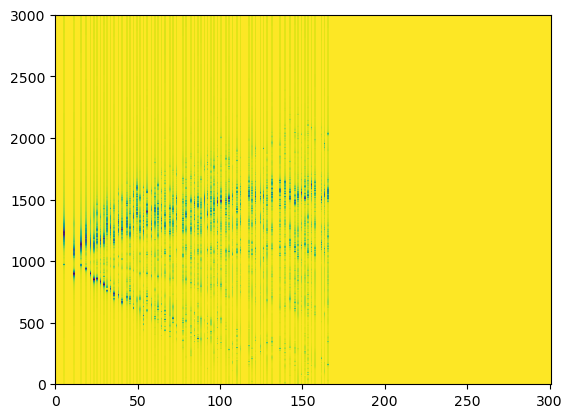

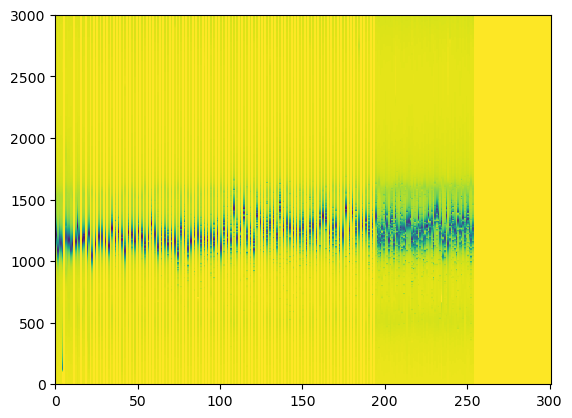

In [46]:
plt.pcolormesh(full_s21_1100)
plt.show()
plt.pcolormesh(full_s21_225)
plt.show()

In [ ]:
def parse_file(filename):
    data = defaultdict(list)  # {Hdc: [(yig_t, [(freq, s21)])]}
    current_hdc = None
    current_yig_t = None
    current_data = []
    parsing_data = False

    with open(filename, 'r') as f:
        frequencies = np.linspace(4.3, 6.4, 3001)
        idx = 0
        for line in f:
            line = line.strip()
            if not line:
                continue

            if line.startswith('#Parameters'):
                # Save previous data
                if current_hdc is not None and current_data:
                    data[current_hdc].append((current_yig_t, current_data))
                
                # Parse new parameters
                params = {}
                param_str = line.split('=', 1)[1].strip(' {}')
                for pair in param_str.split(';'):
                    if not pair.strip():
                        continue
                    key, val = pair.strip().split('=', 1)
                    params[key] = float(val)
                
                current_hdc = int(params['Hdc'])
                current_yig_t = params['yig_t']
                current_data = []
                idx = 0
                parsing_data = False

            elif line.startswith('#'):
                # Data header line, start parsing data
                parsing_data = True
                idx = 0
                continue
            if parsing_data:
                # Read data points
                freq, s21 = map(float, line.split('\t'))
                freq = frequencies[idx]
                idx += 1
                current_data.append((freq, s21))
        
        # Add the last dataset
        if current_hdc is not None and current_data:
            data[current_hdc].append((current_yig_t, current_data))

    return data

def create_matrices(data):
    matrices = {}
    for hdc, datasets in data.items():
        # Get unique yig_t values and sort
        yig_ts = sorted({yt for yt, _ in datasets})
        
        # Collect all unique frequencies
        all_freqs = set()
        for _, datapoints in datasets:
            freqs = [f for f, _ in datapoints]
            all_freqs.update(freqs)
        sorted_freqs = sorted(all_freqs)
        sorted_freqs = np.linspace(4.3, 6.4, 3001)
        
        # Create matrix (freqs x yig_t)
        matrix = np.full((len(sorted_freqs), len(yig_ts)), np.nan)
        freq_idx = {f: i for i, f in enumerate(sorted_freqs)}
        
        for i, (yt, datapoints) in enumerate(datasets):
            col = yig_ts.index(yt)
            for row, (freq, s21) in enumerate(datapoints):
                # row = freq_idx[freq]
                matrix[row, col] = s21
        
        matrices[hdc] = {
            'matrix': matrix,
            'frequencies': sorted_freqs,
            'yig_ts': yig_ts
        }
    return matrices

# def create_matrices(data):
#     matrices = {}
#     for hdc, datasets in data.items():
#         yig_ts = sorted({yt for yt, _ in datasets})
#         all_freqs = sorted({f for _, dp in datasets for f, _ in dp})
#         # all_freqs = np.linspace(4.3, 6.4, 3001)
        
#         # Create matrix with NaNs
#         matrix = np.full((len(all_freqs), len(yig_ts)), np.nan)
#         # matrix = np.full((3001, len(yig_ts)), np.nan)
#         freq_idx = {f: i for i, f in enumerate(all_freqs)}
        
#         row, col = 0,0
#         for _, (yt, datapoints) in enumerate(datasets):
#             for _, s21 in datapoints:
#                 # row = freq_idx[freq]
#                 if not np.isnan(s21):
#                     matrix[row, col] = s21
#                     row += 1
#             col += 1

#         # Remove rows with any NaN values
#         valid_rows = ~np.isnan(matrix).any(axis=1)
#         clean_matrix = matrix[valid_rows]
#         clean_freqs = [all_freqs[i] for i, valid in enumerate(valid_rows) if valid]

#         matrices[hdc] = {
#             'matrix': clean_matrix,
#             'frequencies': clean_freqs,
#             'yig_ts': yig_ts
#         }
#     return matrices


# Usage
data = parse_file(source)
matrices = create_matrices(data)

IndexError: index 3001 is out of bounds for axis 0 with size 3001

Hdc: 1100
Frequencies shape: 3001
YIG thicknesses: [0.01, 0.016644295302013, 0.023288590604027, 0.02993288590604, 0.036577181208054, 0.043221476510067, 0.049865771812081, 0.056510067114094, 0.063154362416107, 0.069798657718121, 0.076442953020134, 0.083087248322148, 0.089731543624161, 0.096375838926174, 0.10302013422819, 0.1096644295302, 0.11630872483221, 0.12295302013423, 0.12959731543624, 0.13624161073826, 0.14288590604027, 0.14953020134228, 0.1561744966443, 0.16281879194631, 0.16946308724832, 0.17610738255034, 0.18275167785235, 0.18939597315436, 0.19604026845638, 0.20268456375839, 0.2093288590604, 0.21597315436242, 0.22261744966443, 0.22926174496644, 0.23590604026846, 0.24255033557047, 0.24919463087248, 0.2558389261745, 0.26248322147651, 0.26912751677852, 0.27577181208054, 0.28241610738255, 0.28906040268456, 0.29570469798658, 0.30234899328859, 0.3089932885906, 0.31563758389262, 0.32228187919463, 0.32892617449664, 0.33557046979866, 0.34221476510067, 0.34885906040268, 0.3555033557047, 

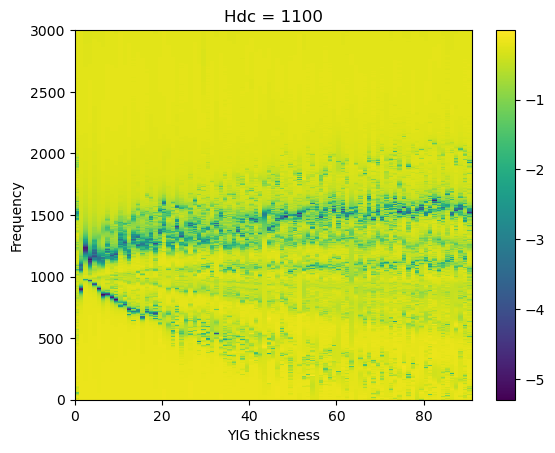

Hdc: 225
Frequencies shape: 3001
YIG thicknesses: [0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.016644295302013, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.023288590604027, 0.02993288590604, 0.036577181208054, 0.043221476510067, 0.049865771812081, 0.056510067114094, 0.063154362416107, 0.069798657718121, 0.076442953020134, 0.083087248322148, 0.089731543624161, 0.096375838926174, 0.10302013422819, 0.1096644295302, 0.11630872483221, 0.12295302013423, 0.12959731543624, 0.13624161073826, 0.14288590604027, 0.14953020134228, 0.1561744966443, 0.16281879194631, 0.16946308724832, 0.17610738255034, 0.18275167785235, 0.18939597315436, 0.19604026845638, 0.20268456375839, 0.2093288590604, 0.21597315436242, 0.22261744966443, 0.22926174496644, 0.23590604026846, 0.24255033557047, 0.24919463087248, 0.2558389261745, 0.26248322147651, 0.26912751677852, 0.27577181208054, 0.28241610738255, 0.28906040268456, 0.29570469798658, 0.30234899328859, 0.3089932885906, 0.31563758389262, 0.32228187919463, 

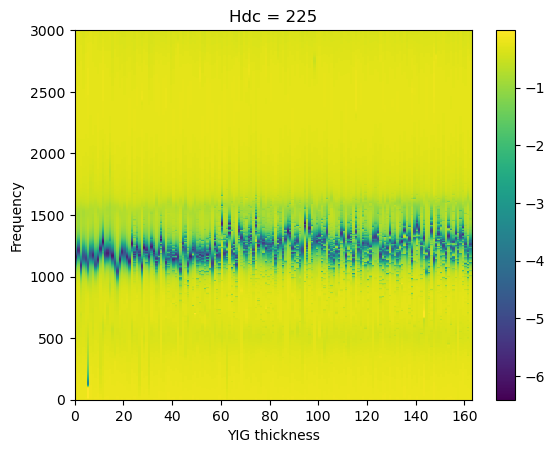

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Access matrices for each Hdc value
for hdc, mdata in matrices.items():
    # mdata['matrix'] = np.nan_to_num(mdata['matrix'])
    print(f"Hdc: {hdc}")
    print(f"Frequencies shape: {mdata['matrix'].shape[0]}")
    print(f"YIG thicknesses: {mdata['yig_ts']}")
    print(f"Frequencies: {mdata['frequencies'][-5:]}")  # Show first 5 elements
    print(f'Frequencies shape: {len(mdata["frequencies"])}')
    print("Matrix sample:")
    print(mdata['matrix'][:5, :5])  # Show first 5x5 elements
    print(mdata['matrix'].shape)
    plt.pcolormesh(mdata['matrix'], cmap='viridis')#, norm=colors.LogNorm(vmin=mdata['matrix'].min(), vmax=mdata['matrix'].max()))
    plt.xlabel('YIG thickness')
    plt.ylabel('Frequency')
    plt.title(f'Hdc = {hdc}')
    plt.colorbar()
    plt.show()
